# Dataset Exploration and Preparation

Imports

In [1]:
import pandas as pd
import numpy as np 

Read File

In [2]:
file_path='./data/CTG.xls'
df_data_clean = pd.read_excel(file_path,'Data')
df_raw = pd.read_excel(file_path,'Raw Data',skiprows=[1,2])
print(df_raw)

          FileName       Date      SegFile       b       e    LBE     LB   AC  \
0       Fmcs_1.txt 1996-05-03  CTG0002.txt     5.0   632.0  132.0  132.0  4.0   
1       Fmcs_1.txt 1996-05-03  CTG0003.txt   177.0   779.0  133.0  133.0  2.0   
2       Fmcs_1.txt 1996-05-03  CTG0004.txt   411.0  1192.0  134.0  134.0  2.0   
3       Fmcs_1.txt 1996-05-03  CTG0005.txt   533.0  1147.0  132.0  132.0  4.0   
4       Fmcs_2.txt 1996-05-03  CTG0006.txt     0.0   953.0  134.0  134.0  1.0   
...            ...        ...          ...     ...     ...    ...    ...  ...   
2123  S8001045.dsp 1998-06-06  CTG2127.txt  1576.0  3049.0  140.0  140.0  1.0   
2124  S8001045.dsp 1998-06-06  CTG2128.txt  2796.0  3415.0  142.0  142.0  1.0   
2125           NaN        NaT          NaN     NaN     NaN    NaN    NaN  NaN   
2126           NaN        NaT          NaN     NaN     NaN    NaN    NaN  NaN   
2127           NaN        NaT          NaN     NaN     NaN    NaN    NaN  NaN   

         FM    UC  ...    C

Data Cleaning: NaN

In [3]:
df_raw.isnull().values.any() 

True

In [4]:
df_raw.columns[df_raw.isnull().any()].tolist() #list of columns with NaN

['FileName',
 'Date',
 'SegFile',
 'b',
 'e',
 'LBE',
 'LB',
 'AC',
 'FM',
 'UC',
 'ASTV',
 'MSTV',
 'ALTV',
 'MLTV',
 'DL',
 'DS',
 'DP',
 'DR',
 'Width',
 'Min',
 'Max',
 'Nmax',
 'Nzeros',
 'Mode',
 'Mean',
 'Median',
 'Variance',
 'Tendency',
 'A',
 'B',
 'C',
 'D',
 'E',
 'AD',
 'DE',
 'LD',
 'FS',
 'SUSP',
 'CLASS',
 'NSP']

In [5]:
df_raw = df_raw.iloc[:-3,:] #removing last three rows as per document 

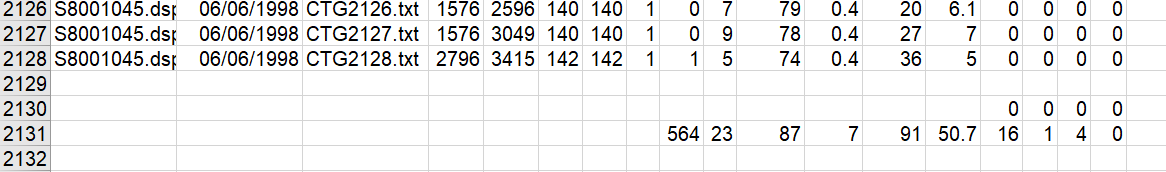

In [6]:
df_raw.isnull().values.any() #faster than isna or sum

False

NaN removed

In [7]:
(df_raw["DR"]==0).all() #double check

True

Extract features name

In [8]:
features = pd.read_excel(file_path, usecols='J:J',sheet_name='Description', skiprows=5, nrows=21)['Features'].tolist()

Calculating correlation matrix

In [9]:
df_raw_measures = df_raw.loc[:,features]

In [10]:
corr_m=df_raw_measures.corr()

<Axes: title={'center': 'Features correlation matrix'}>

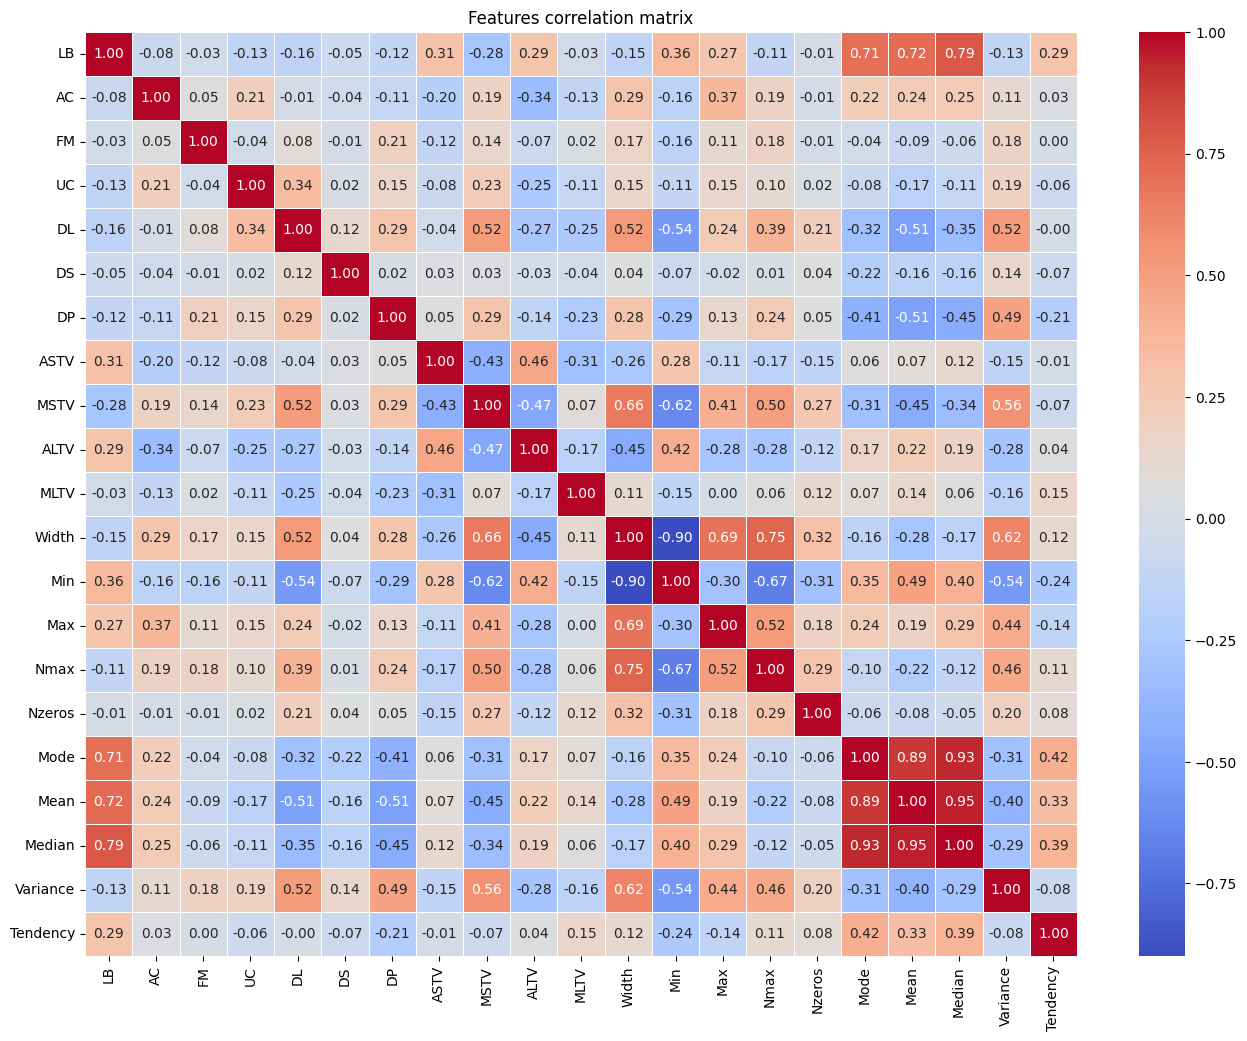

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt 
fig,ax=plt.subplots(figsize=(16,12))
ax.set_title("Features correlation matrix")
sns.heatmap(corr_m, annot=True, ax=ax,cmap='coolwarm', fmt=".2f", linewidths=0.5)

In [12]:
import scipy as sp 

norm_df=sp.stats.zscore(df_raw_measures)

<Axes: title={'center': 'Normalized features box plot representation'}>

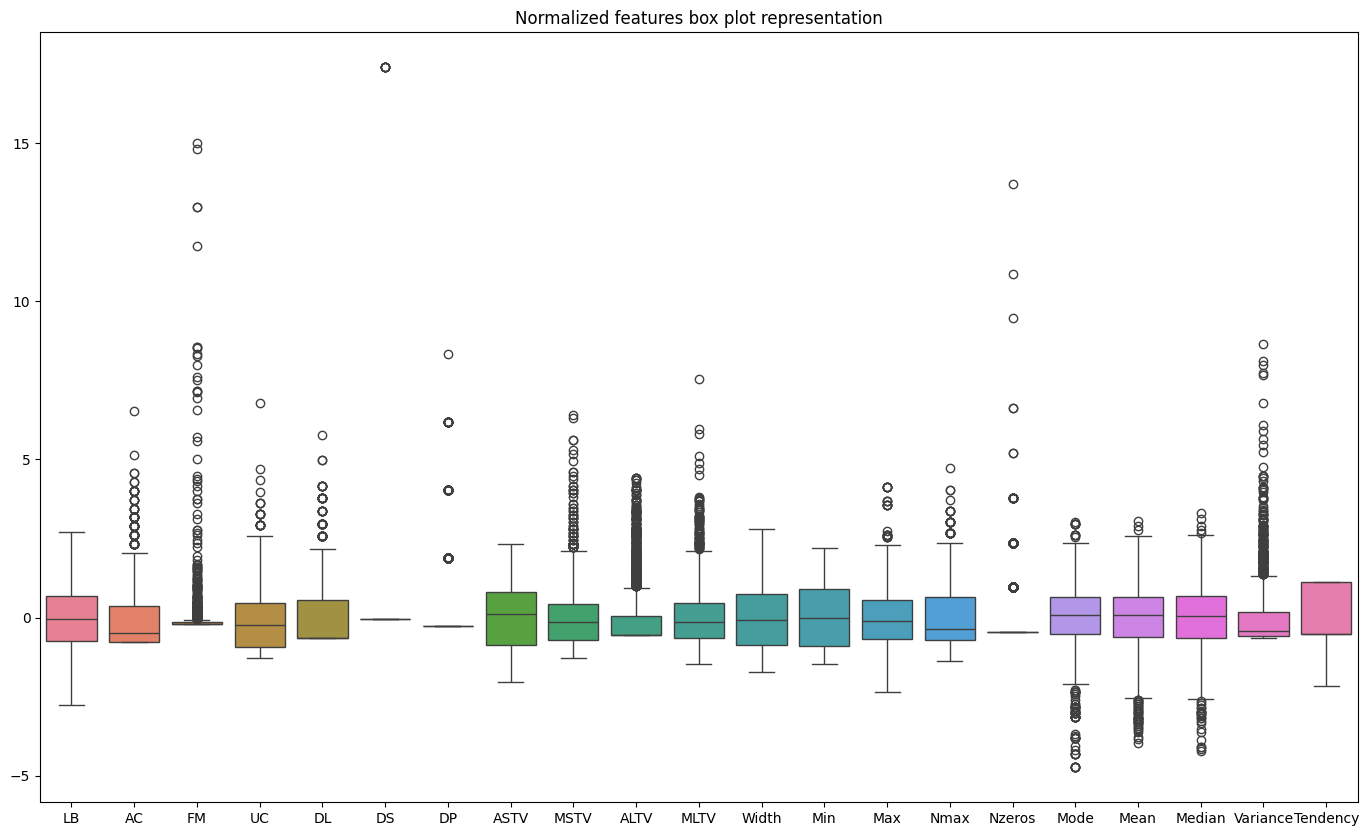

In [13]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(17,10))
ax.set_title("Normalized features box plot representation")
sns.boxplot(norm_df,ax=ax)

Outcome: some features are correlated and there are outliers

## Dataset preparation

Include NSP prediction class

In [14]:
features_with_prediction_class=features+['NSP']

In [15]:
df_raw_measures_tot = df_raw.loc[:,features_with_prediction_class]

Check for unbalance in target class

In [16]:
occurrences_per_class=df_raw_measures_tot['NSP'].value_counts().tolist()
class_names=['N','S','P']

c:\Users\hp\Downloads\Work\Eni\DataChallenge\Development\EniDataChallenge\utils\plot_helper.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=occurrences_per_class, palette="pastel", ax=ax[1])
c:\Users\hp\Downloads\Work\Eni\DataChallenge\Development\EniDataChallenge\utils\plot_helper.py:129: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


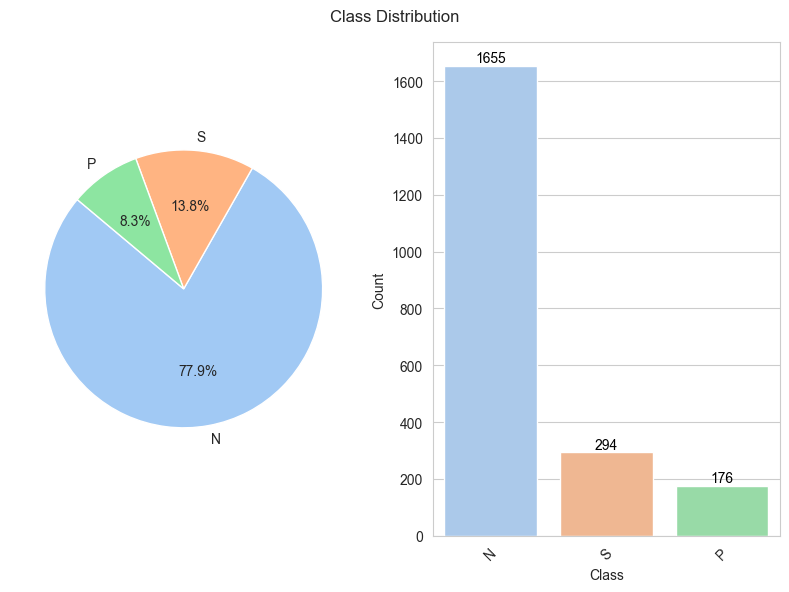

In [17]:
from utils import plot_helper
plot_helper.plot_target_class_occurences(occurrences_per_class,class_names)

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X_no_preprocessing_all=df_raw_measures_tot
X_no_outliers_all=df_raw_measures_tot[(np.abs(sp.stats.zscore(df_raw_measures_tot)) < 3).all(axis=1)] #excluding the +-3 sigma

X_no_preprocessing=X_no_preprocessing_all.loc[:,features]
X_no_outliers=X_no_outliers_all.loc[:,features]

y_no_preprocessing = X_no_preprocessing_all.loc[:,'NSP'].astype('uint8')
y_no_outliers = X_no_outliers_all.loc[:,'NSP'].astype('uint8')

y_no_preprocessing_encode = le.fit_transform(y_no_preprocessing)
y_no_outliers_encode = le.fit_transform(y_no_outliers)

In [19]:
X_no_preprocessing.shape,X_no_outliers.shape,y_no_preprocessing_encode.shape,y_no_outliers_encode.shape

((2125, 21), (1781, 21), (2125,), (1781,))

## ML Algorithms

Train, val, test split

In [20]:
train_data=[]
test_data=[]

In [21]:
from sklearn.model_selection import train_test_split

X_train_no_preprocessing, X_test_no_preprocessing, y_train_no_preprocessing, y_test_no_preprocessing = train_test_split(X_no_preprocessing, y_no_preprocessing_encode, test_size=0.2, random_state=1)
train_data.append((X_train_no_preprocessing, y_train_no_preprocessing))
test_data.append((X_test_no_preprocessing, y_test_no_preprocessing))
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(X_no_outliers, y_no_outliers_encode, test_size=0.2, random_state=1)
train_data.append((X_train_no_outliers, y_train_no_outliers))
test_data.append((X_test_no_outliers, y_test_no_outliers))

Oversample training dataset

In [22]:
from imblearn.over_sampling import SMOTE
oversample=SMOTE()
X_ov_no_preprocessing,y_ov_no_preprocessing = oversample.fit_resample(X_train_no_preprocessing,y_train_no_preprocessing)
train_data.append((X_ov_no_preprocessing,y_ov_no_preprocessing))
X_ov_no_outliers,y_ov_no_outliers = oversample.fit_resample(X_train_no_outliers,y_train_no_outliers)
train_data.append((X_ov_no_outliers,y_ov_no_outliers))

In [23]:
_,ov_counts=np.unique(y_ov_no_outliers,return_counts=True)

c:\Users\hp\Downloads\Work\Eni\DataChallenge\Development\EniDataChallenge\utils\plot_helper.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=occurrences_per_class, palette="pastel", ax=ax[1])
c:\Users\hp\Downloads\Work\Eni\DataChallenge\Development\EniDataChallenge\utils\plot_helper.py:129: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


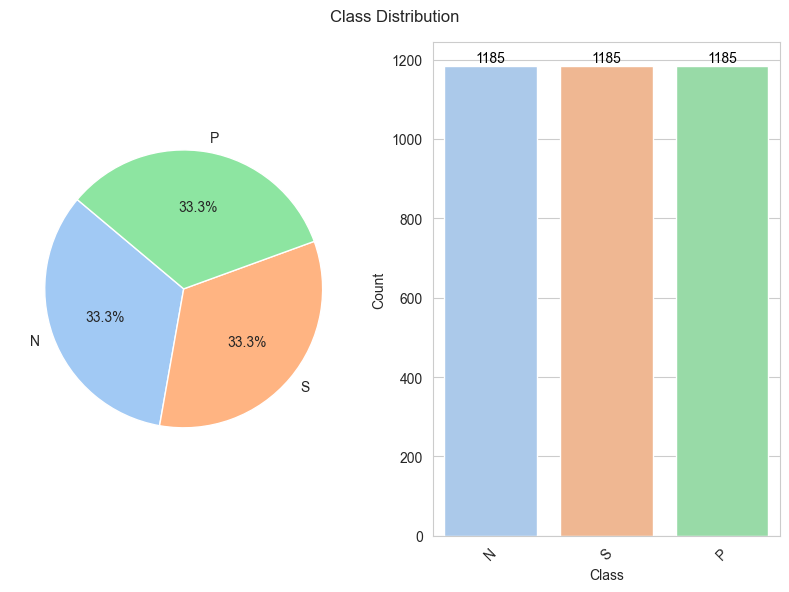

In [25]:
plot_helper.plot_target_class_occurences(ov_counts,class_names)

Imports

In [26]:
# Sklearn >>>>
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold,KFold, GridSearchCV
import xgboost as xgb
from lightgbm import LGBMClassifier

In [27]:
data_names=['no_preprocessing','no_outliers','ov_no_preprocessing','ov_no_outliers']

In [28]:
#requested classifiers
classif=[('kn',KNeighborsClassifier()),('gnb',GaussianNB()),('svm',SVC()),('rf',RandomForestClassifier()),('xgb',xgb.XGBClassifier()),('lgbm',LGBMClassifier())]

classif_names=[x[0] for x in classif] 

#build one pipeline for each classifier
pipes = [Pipeline([
    ('scaling', StandardScaler(with_mean=True)),
    i]) for i in classif]

# Parameters of pipelines can be set using ‘__’ separated parameter names:
params_grid = [
    {'kn__n_neighbors':[2,5,10,20],'kn__algorithm':['auto','brute'],'kn__p':[1,2]},
    {},
    {'svm__C': [1, 10, 100, 1000], 'svm__gamma': [0.001, 0.0001], 'svm__kernel': ['rbf']},
    {'rf__n_estimators':[10,100,200]},
    {'xgb__tree_method':['hist'],'xgb__n_estimators':[10,100,200],'xgb__learning_rate':[0.1,0.01]}, 
    {'lgbm__learning_rate':[0.1,0.01],'lgbm__subsample_for_bin':[1000,2000,200000],'lgbm__objective':['multiclass']}            
    ]

cv_scoring= ['precision_macro', 'recall_macro']

scores={}
estimators={}

for name,data in zip(data_names,train_data):
    scores[name]=[]
    estimators[name]=[]
    print(f"evaluating dataset {name}")
    for i,(pipe,param) in enumerate(zip(pipes,params_grid)):
        group=StratifiedKFold(n_splits=3)
        
        search = GridSearchCV(pipe, param, n_jobs=-1,cv=group)
        
        # here i am going to fit all:

        search.fit(data[0], data[1]) 

        best_estimator2=search.best_estimator_.fit(data[0], data[1])

        print("Best parameter (CV score=%0.3f):" % search.best_score_)
        print(search.best_params_)
        scores[name].append(search.best_score_)
        estimators[name].append(best_estimator2)


evaluating dataset no_preprocessing
Best parameter (CV score=0.904):
{'kn__algorithm': 'auto', 'kn__n_neighbors': 2, 'kn__p': 1}
Best parameter (CV score=0.735):
{}
Best parameter (CV score=0.919):
{'svm__C': 1000, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
Best parameter (CV score=0.942):
{'rf__n_estimators': 200}
Best parameter (CV score=0.950):
{'xgb__learning_rate': 0.1, 'xgb__n_estimators': 100, 'xgb__tree_method': 'hist'}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1228
[LightGBM] [Info] Number of data points in the train set: 1700, number of used features: 20
[LightGBM] [Info] Start training from score -0.252239
[LightGBM] [Info] Start training from score -1.978798
[LightGBM] [Info] Start training from score -2.468570
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise mu

In [29]:
data_names

['no_preprocessing', 'no_outliers', 'ov_no_preprocessing', 'ov_no_outliers']

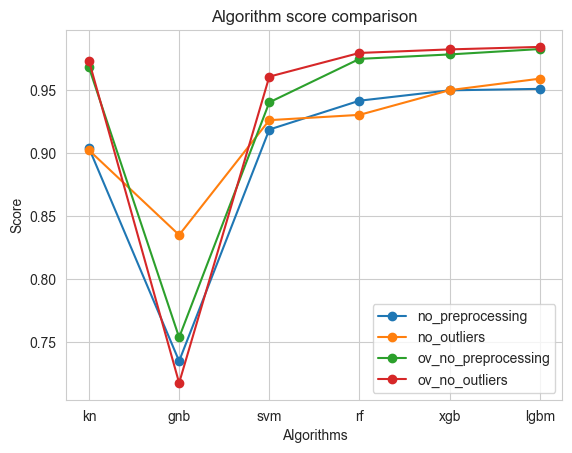

In [30]:
for name in data_names:
    plt.plot(scores[name],'-o',label=name)
    plt.grid()
    plt.ylabel("Score")
    plt.xlabel("Algorithms")
    plt.title("Algorithm score comparison")
    plt.xticks(ticks=np.arange(0,len(scores[name])),labels=classif_names)
    plt.legend()

LGBM provides best result, use it for inference 

In [31]:
best_algo_name,best_algo=classif_names[-1],estimators['ov_no_outliers'][-1]

In [32]:
best_algo

Pipeline(steps=[('scaling', StandardScaler()),
                ('lgbm',
                 LGBMClassifier(objective='multiclass',
                                subsample_for_bin=2000))])

############### classification report of classifier lgbm ###############
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       334
           1       0.88      0.97      0.92        59
           2       1.00      0.59      0.75        32

    accuracy                           0.96       425
   macro avg       0.95      0.85      0.88       425
weighted avg       0.96      0.96      0.96       425

############### Confusion matrix of classifier lgbm ###############
############### classification report of classifier lgbm ###############
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       295
           1       0.85      0.92      0.89        51
           2       0.78      0.64      0.70        11

    accuracy                           0.95       357
   macro avg       0.87      0.84      0.85       357
weighted avg       0.95      0.95      0.95       357

############### Confusio

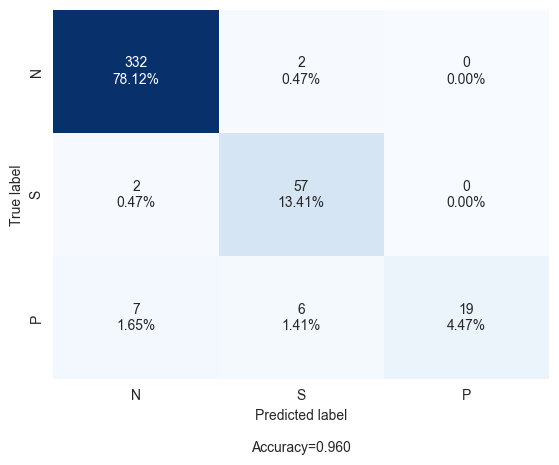

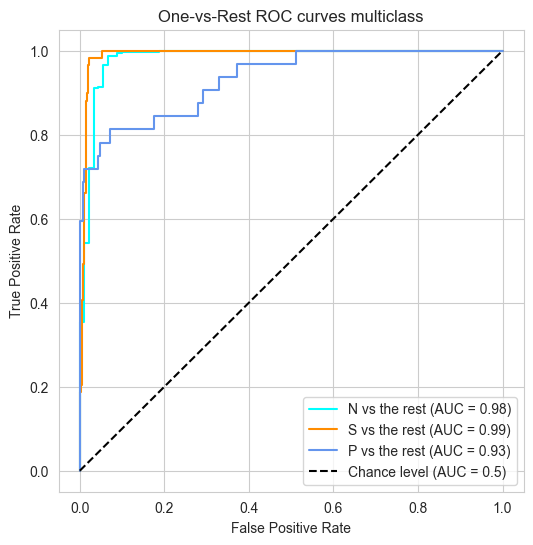

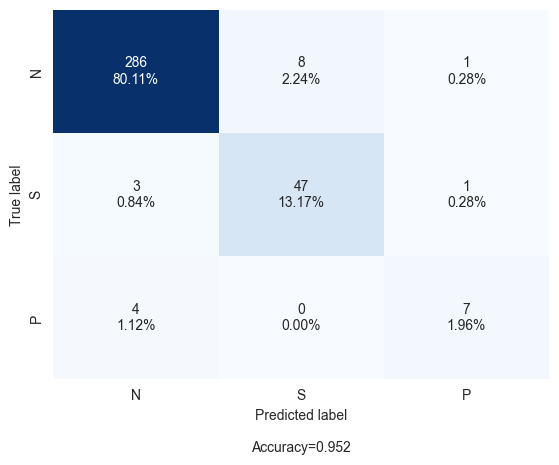

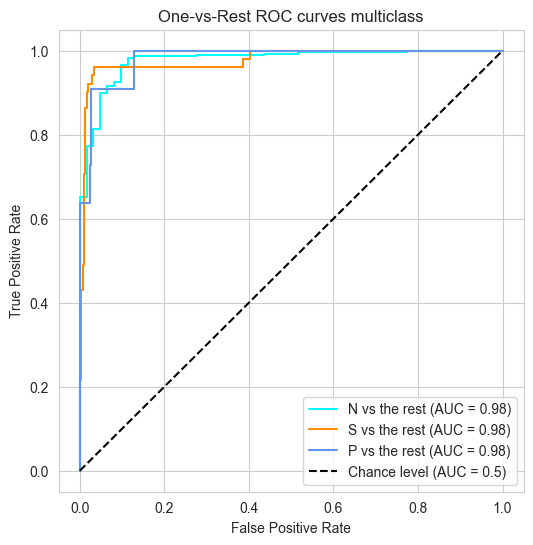

In [33]:
from sklearn.metrics import classification_report,confusion_matrix
from utils import plot_helper
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

label_binarizer = LabelBinarizer().fit(y_train_no_preprocessing)


for d in test_data:
    y_pred=best_algo.predict(d[0])
    y_score=best_algo.predict_proba(d[0])
    print(f"############### classification report of classifier {best_algo_name} ###############")
    print(f"{classification_report(d[1], y_pred)}")

    print(f"############### Confusion matrix of classifier {best_algo_name} ###############") 
    cm=confusion_matrix(d[1],y_pred)
    plot_helper.make_confusion_matrix(cm,categories=["N","S","P"],cbar=False)
    
    y_onehot_test = label_binarizer.transform(d[1])

    fig, ax = plt.subplots(figsize=(6, 6))

    colors = ["aqua", "darkorange", "cornflowerblue"]

    class_map={0:'N',1:'S',2:'P'}

    class_ids_len=len(class_map.values())
    for class_id,color in zip(range(class_ids_len),colors):
        class_of_interest=class_map[class_id]
        display = RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{class_of_interest} vs the rest",
            color=color,
            ax=ax,
            plot_chance_level=(class_id==2)
            )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="One-vs-Rest ROC curves multiclass",
    )